In [ ]:
!pip install huggingface_hub(cli)
!pip install utilsforecast
!pip install praxis
!pip install paxml
!pip install jax[cuda12]==0.4.26
!pip install einshape
!pip install timesfm[pax]

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install huggingface_hub(cli)'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and pra

In [ ]:
import timesfm
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7981 entries, 1993-08-12 00:00:00-04:00 to 2025-04-25 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          7981 non-null   float64
 1   High          7981 non-null   float64
 2   Low           7981 non-null   float64
 3   Close         7981 non-null   float64
 4   Volume        7981 non-null   int64  
 5   Dividends     7981 non-null   float64
 6   Stock Splits  7981 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 498.8 KB
                            ds       Open unique_id
0    1993-08-12 00:00:00-04:00   2.790388       EQR
1    1993-08-13 00:00:00-04:00   2.742278       EQR
2    1993-08-16 00:00:00-04:00   2.670113       EQR
3    1993-08-17 00:00:00-04:00   2.694170       EQR
4    1993-08-18 00:00:00-04:00   2.706197       EQR
...                        ...        ...       ...
7976 2025-04-21 00:00:00-04:00  67.639999  

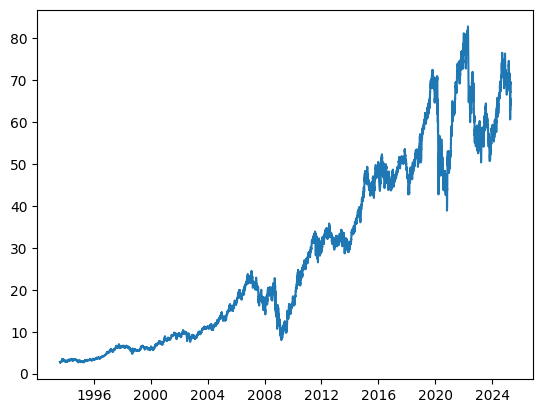

In [ ]:
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df.info()

df = df.reset_index()
df.rename(columns={'Date': 'ds'}, inplace=True)

df = df[['ds', 'Open']]

df['unique_id']='EQR'

plt.plot(df['ds'], df['Open'])

print(df)

In [ ]:
train_end = round(len(df) * 0.9)

train = df[:train_end]
test = df[train_end:]

# Upewnij się, że kolumna 'ds' jest datetime
df['ds'] = pd.to_datetime(df['ds'])

# Pobierz datę z kolumny 'ds' zamiast z indeksu:
start_date = df['ds'].iloc[train_end]
date_list = pd.date_range(start_date, periods=11, freq="30d").tolist()
print(date_list)

[Timestamp('2022-02-18 00:00:00-0500', tz='America/New_York'), Timestamp('2022-03-20 00:00:00-0400', tz='America/New_York'), Timestamp('2022-04-19 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-19 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-18 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-18 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-17 00:00:00-0400', tz='America/New_York'), Timestamp('2022-09-16 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-16 00:00:00-0400', tz='America/New_York'), Timestamp('2022-11-15 00:00:00-0500', tz='America/New_York'), Timestamp('2022-12-15 00:00:00-0500', tz='America/New_York')]


In [ ]:
tfm_eqr = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2304,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.02020605720311944


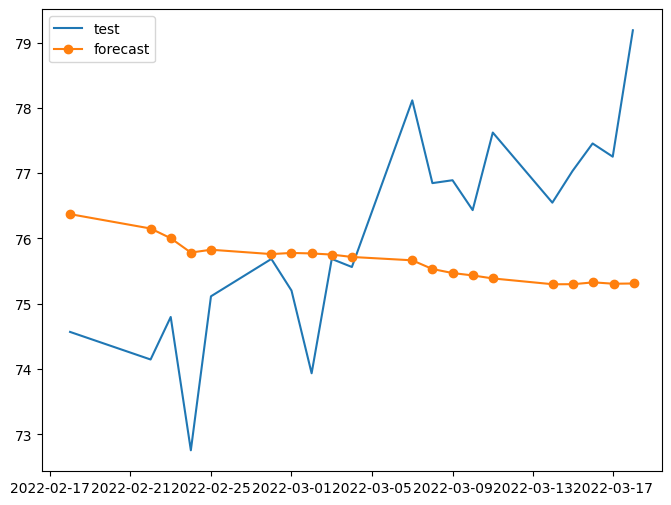

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.021866482416934552


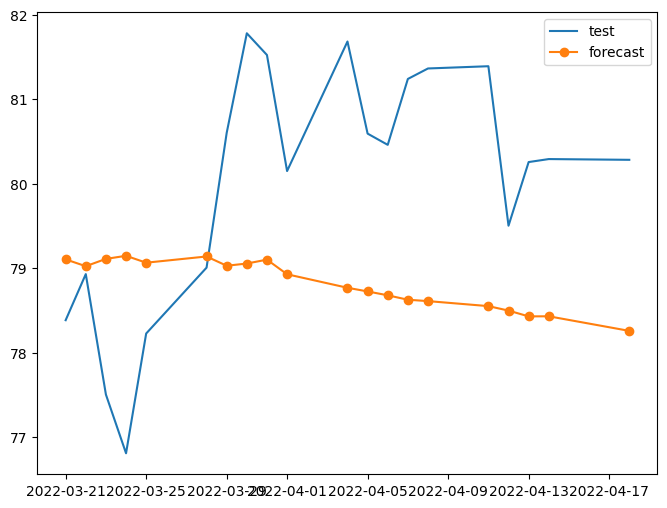

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.11270514410334466


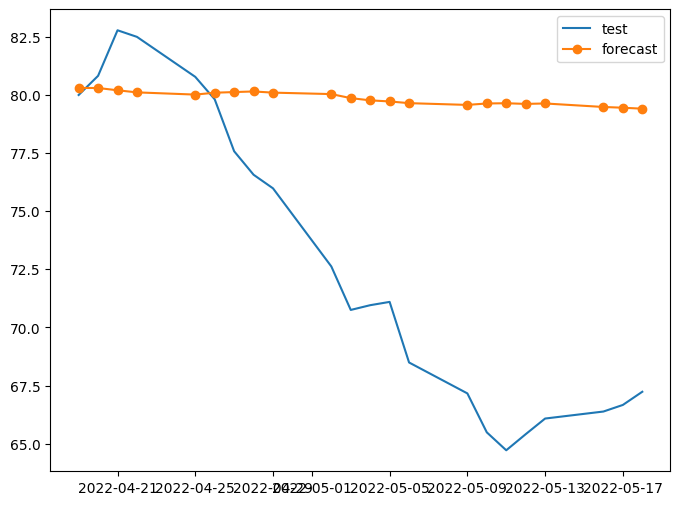

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.03360660805680086


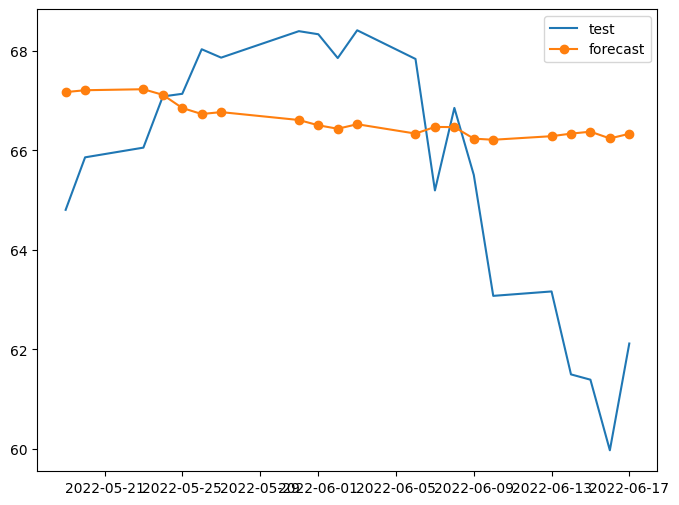

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.04427299970201657


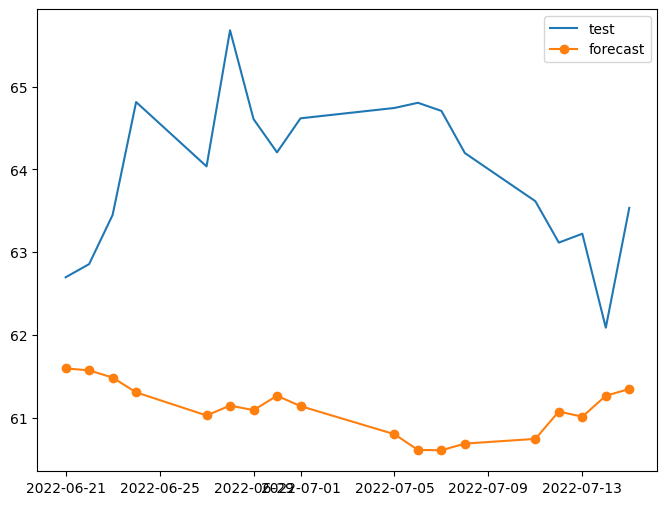

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.04928633490363852


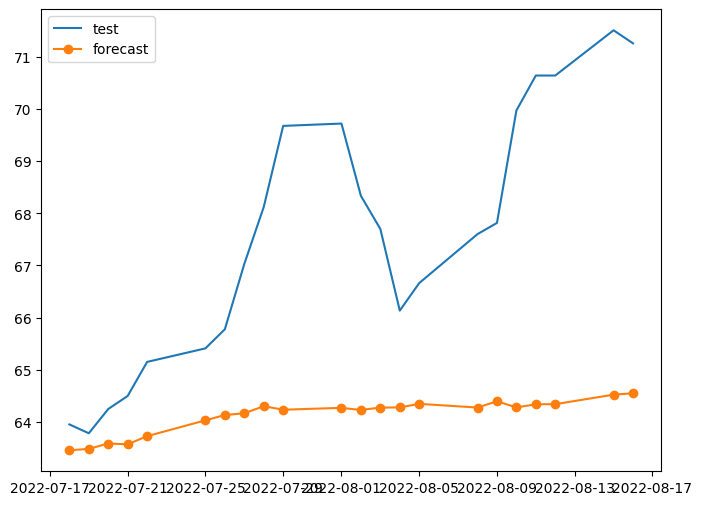

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.055297079474701874


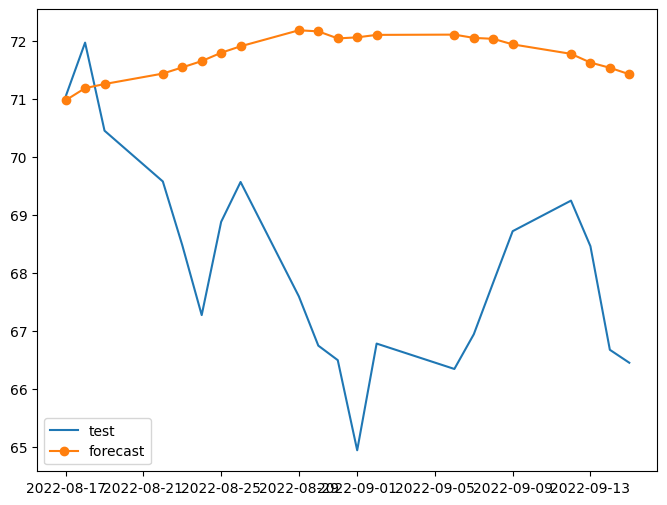

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.11298211656124879


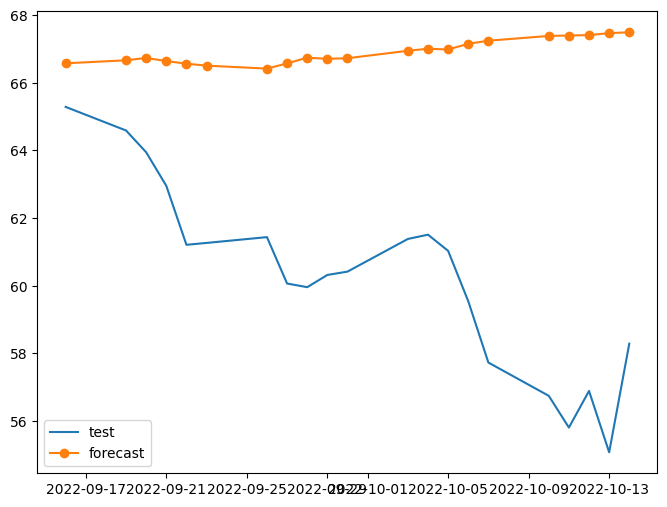

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.030149619411205558


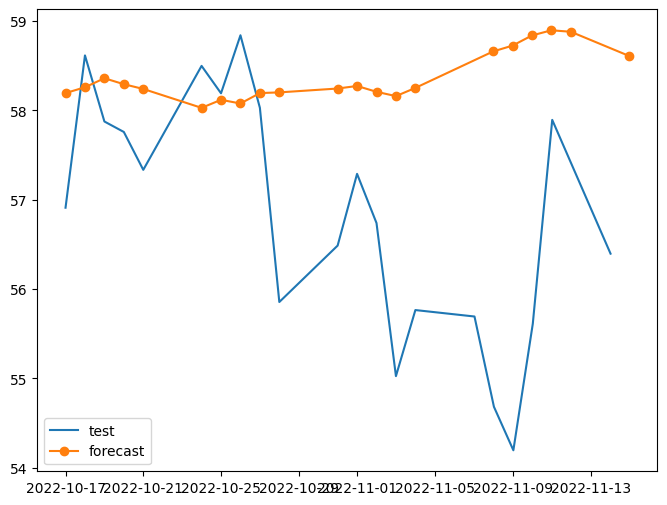

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.018646328622997872


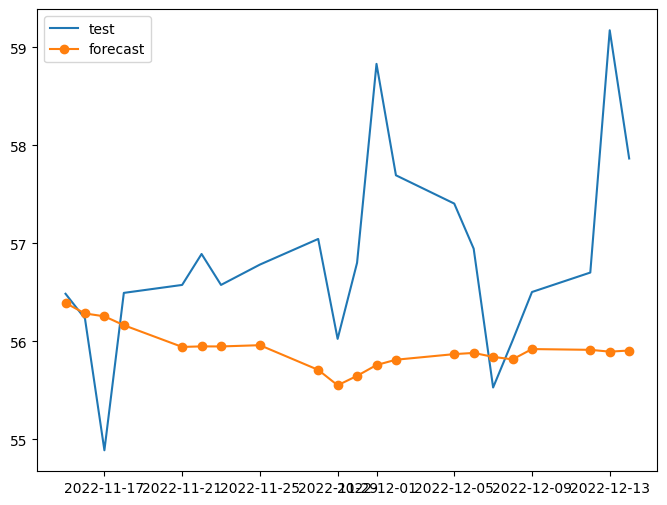

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.0797530618346549


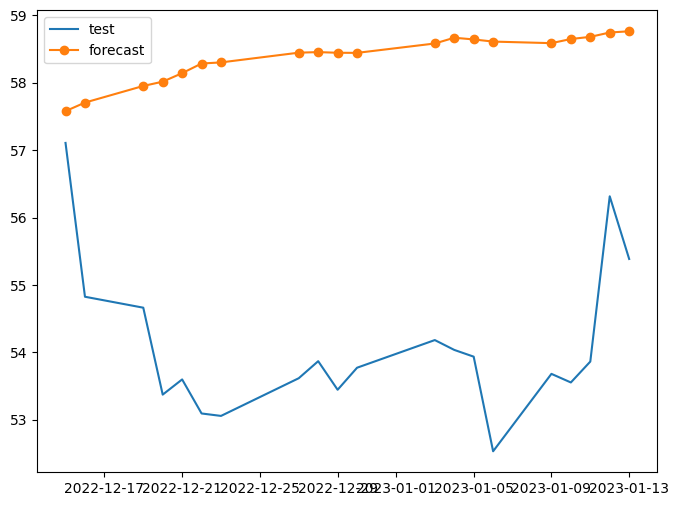

In [ ]:
df_forecasts=[]
mapes=[]

for d in date_list:
  train_df = df[df['ds'] < d].copy()
  subtest = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=30))]

  forecast_df = tfm_eqr.forecast_on_df(
      inputs=train_df,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )

  df_forecasts.append(forecast_df)
  forecast_subset = forecast_df[forecast_df['ds'].dt.date.isin(subtest['ds'].dt.date)]

  mape=mean_absolute_percentage_error(subtest['Open'], forecast_subset['timesfm'])
  print("MAPE: ", mape)
  mapes.append(mape)

  plt.figure(figsize=(8,6))
  plt.plot(subtest['ds'], subtest['Open'], label="test")
  plt.plot(forecast_subset['ds'], forecast_subset['timesfm'], label="forecast", marker='o')
  plt.legend()
  plt.show()



In [ ]:
print("Average MAPE:", sum(mapes)/len(mapes))

Average MAPE: 0.05261562111733305


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.2 MB/s eta 0:00:00


In [ ]:
import optuna
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import timesfm

# załaduj checkpoint raz na zewnątrz
checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
)

def objective(trial):
  try:
    # --- próbujemy tylko "bezpieczne" parametry ---
    context_len        = trial.suggest_int("context_len", 256, 2048, step=32)
    horizon_len        = trial.suggest_int("horizon_len", 16, 128, step=16)
    per_core_batch_size= trial.suggest_categorical("per_core_batch_size", [16,32,64])

    # --- architektura modelu jak w checkpointcie ---
    hparams = timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=per_core_batch_size,
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
    )

    # inicjalizacja i forecast
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)
    mapes = []
    for d in date_list[:5]:  # szybka ewaluacja na 5 oknach
        train_df = df[df['ds'] < d]
        subtest  = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=30))]
        fc       = tfm.forecast_on_df(train_df, freq="1D", value_name="Open", num_jobs=-1)

        # bezpieczne dopasowanie dat
        merged = pd.merge(
            subtest[['ds', 'Open']],
            fc[['ds', 'timesfm']],
            on='ds',
            how='inner'
        )
        if len(merged) < 2:  # za mało punktów do sensownej MAPE
            return float('inf')
        mapes.append(mean_absolute_percentage_error(
            merged['Open'].values,
            merged['timesfm'].values
        ))

    return sum(mapes) / len(mapes)

  except ValueError as e:
        # opcjonalnie: trial.set_user_attr("error", str(e))
        return float('inf')

# uruchomienie searchu
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=20)
print("Best MAPE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-04-27 15:40:27,193] A new study created in memory with name: no-name-1bf7de60-3c76-4825-8038-945b3df0d878


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:41:21,858] Trial 0 finished with value: 0.047759755891632366 and parameters: {'context_len': 384, 'horizon_len': 96, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.047759755891632366.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:42:49,064] Trial 1 finished with value: 0.0496946092568485 and parameters: {'context_len': 448, 'horizon_len': 80, 'per_core_batch_size': 64}. Best is trial 0 with value: 0.047759755891632366.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:46:25,611] Trial 2 finished with value: 0.04162508093773078 and parameters: {'context_len': 1248, 'horizon_len': 128, 'per_core_batch_size': 64}. Best is trial 2 with value: 0.04162508093773078.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:47:51,920] Trial 3 finished with value: 0.028480011704198088 and parameters: {'context_len': 1856, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:53:11,837] Trial 4 finished with value: 0.04580228116375445 and parameters: {'context_len': 1856, 'horizon_len': 128, 'per_core_batch_size': 64}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 15:57:08,717] Trial 5 finished with value: 0.043337396488780155 and parameters: {'context_len': 1376, 'horizon_len': 112, 'per_core_batch_size': 64}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:01:18,958] Trial 6 finished with value: 0.04331868545575368 and parameters: {'context_len': 1472, 'horizon_len': 64, 'per_core_batch_size': 64}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:03:05,663] Trial 7 finished with value: 0.044055164500241814 and parameters: {'context_len': 1152, 'horizon_len': 96, 'per_core_batch_size': 32}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:03:36,236] Trial 8 finished with value: 0.04815511564502798 and parameters: {'context_len': 256, 'horizon_len': 64, 'per_core_batch_size': 32}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:05:27,418] Trial 9 finished with value: 0.04162508093773078 and parameters: {'context_len': 1248, 'horizon_len': 32, 'per_core_batch_size': 32}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:07:00,904] Trial 10 finished with value: 0.03154787071039095 and parameters: {'context_len': 2048, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:08:31,136] Trial 11 finished with value: 0.029482733119498887 and parameters: {'context_len': 1984, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:09:50,776] Trial 12 finished with value: 0.04519817064994182 and parameters: {'context_len': 1728, 'horizon_len': 32, 'per_core_batch_size': 16}. Best is trial 3 with value: 0.028480011704198088.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:10:36,628] Trial 13 finished with value: 0.0279728890727566 and parameters: {'context_len': 864, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 13 with value: 0.0279728890727566.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:11:26,493] Trial 14 finished with value: 0.05076223326786387 and parameters: {'context_len': 864, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 13 with value: 0.0279728890727566.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:12:10,693] Trial 15 finished with value: 0.04767035574839425 and parameters: {'context_len': 768, 'horizon_len': 32, 'per_core_batch_size': 16}. Best is trial 13 with value: 0.0279728890727566.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:12:55,143] Trial 16 finished with value: 0.02676234421693684 and parameters: {'context_len': 832, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 16 with value: 0.02676234421693684.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:13:39,106] Trial 17 finished with value: 0.04854432590487177 and parameters: {'context_len': 832, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 16 with value: 0.02676234421693684.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:14:11,874] Trial 18 finished with value: 0.04994052068529971 and parameters: {'context_len': 576, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 16 with value: 0.02676234421693684.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 16:15:06,883] Trial 19 finished with value: 0.02655933723823321 and parameters: {'context_len': 1088, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 19 with value: 0.02655933723823321.


Finished forecasting.
Best MAPE: 0.02655933723823321
Best params: {'context_len': 1088, 'horizon_len': 16, 'per_core_batch_size': 16}


#### Best params: {'context_len': 800, 'horizon_len': 16, 'per_core_batch_size': 16}  5 trials
#### Best params: {'context_len': 1088, 'horizon_len': 16, 'per_core_batch_size': 16}  20 trials

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.015228027599570542


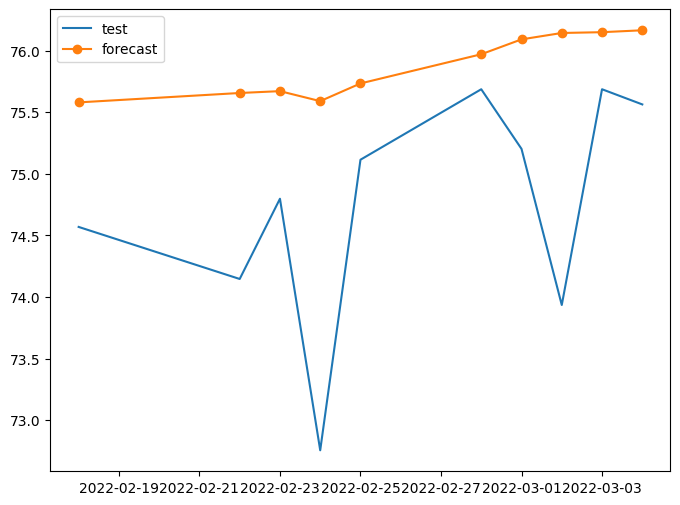

Average MAPE: 0.015228027599570542
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Uwaga: tylko 5 punktów do ewaluacji
MAPE:  0.018062078465165644


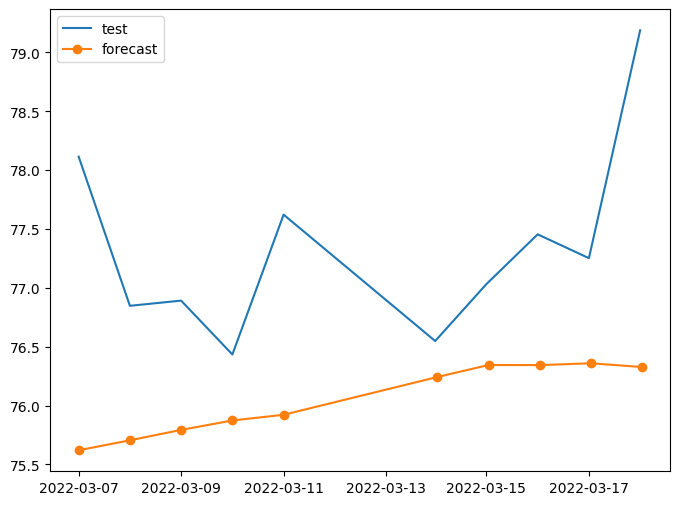

Average MAPE: 0.016645053032368094
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.014338369371065127


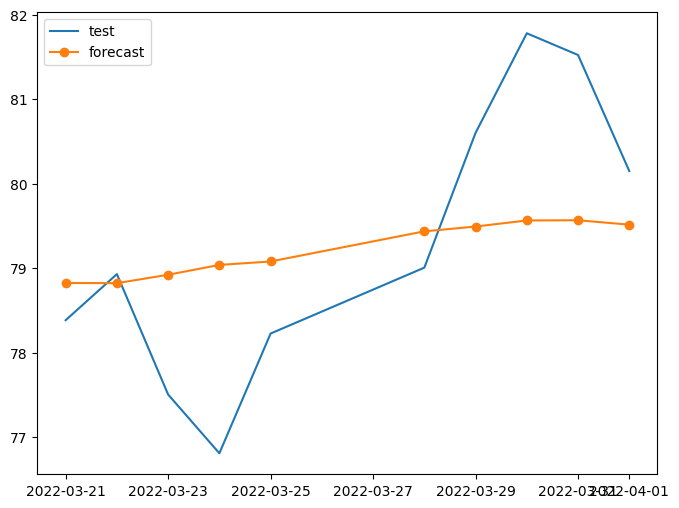

Average MAPE: 0.01587615847860044
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.009382025293291936


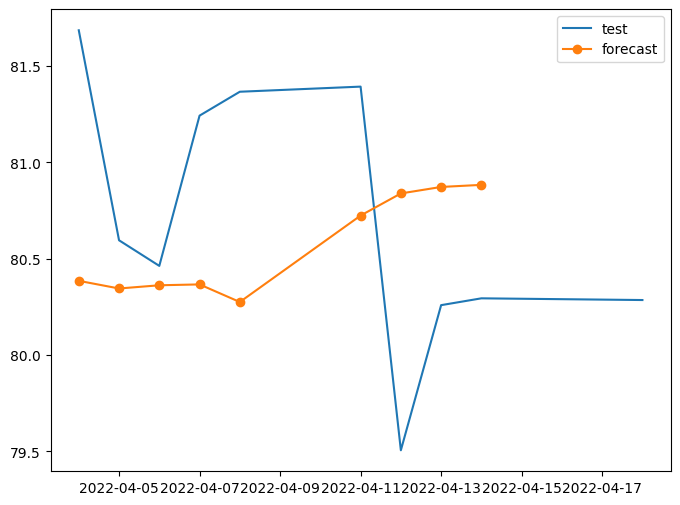

Average MAPE: 0.014252625182273312
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.04180535908664696


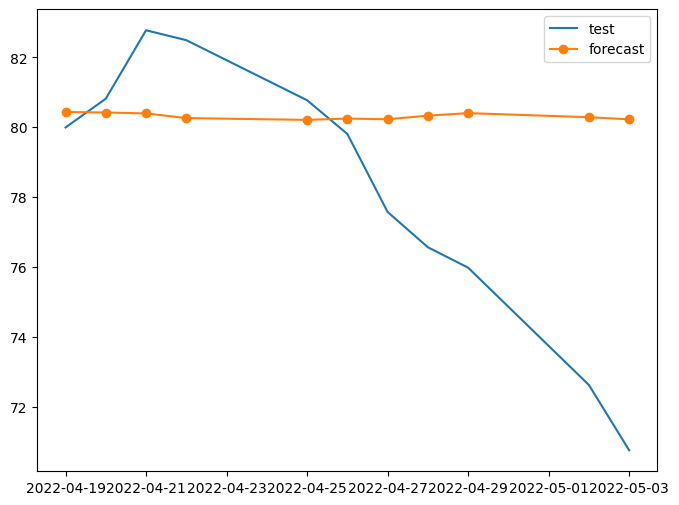

Average MAPE: 0.01976317196314804
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.06207539531434613


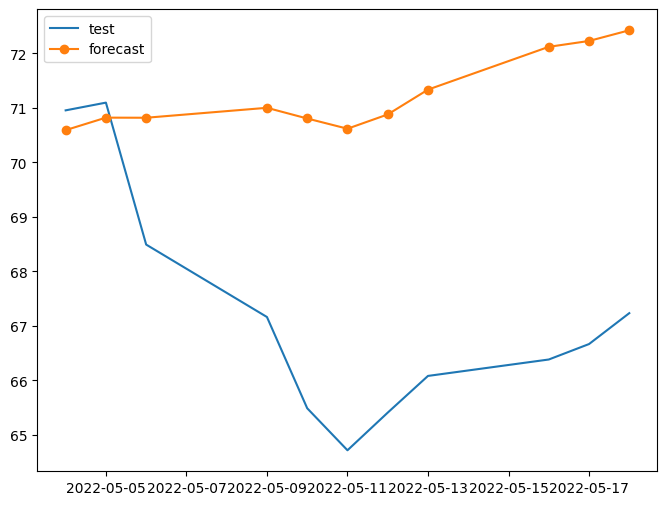

Average MAPE: 0.026815209188347722
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.015512479783180494


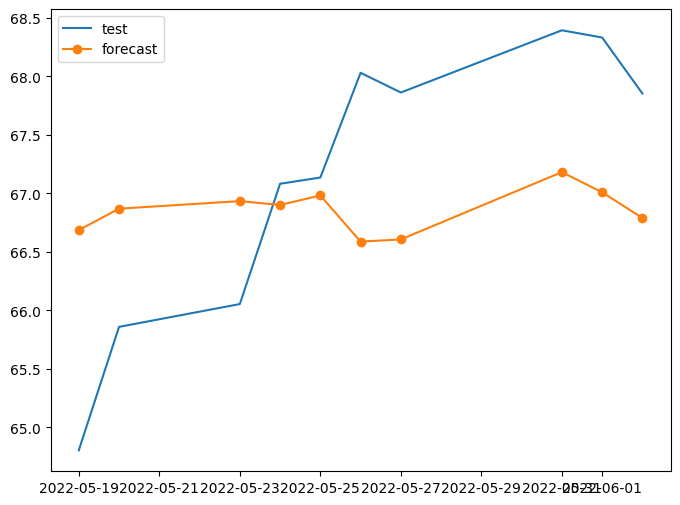

Average MAPE: 0.02520053355903812
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.07382145164633999


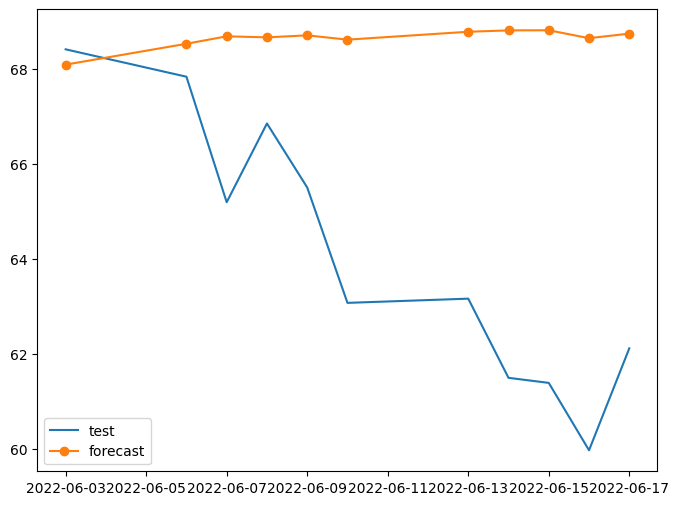

Average MAPE: 0.03127814831995085
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.037791856923161664


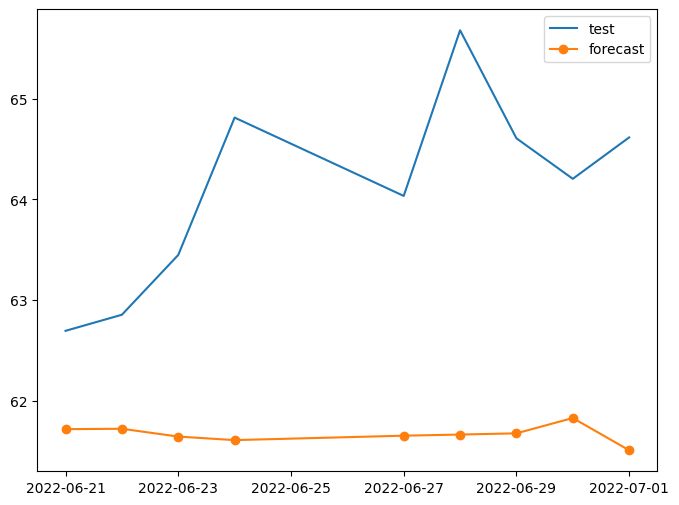

Average MAPE: 0.03200189372030761
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.017033967929187887


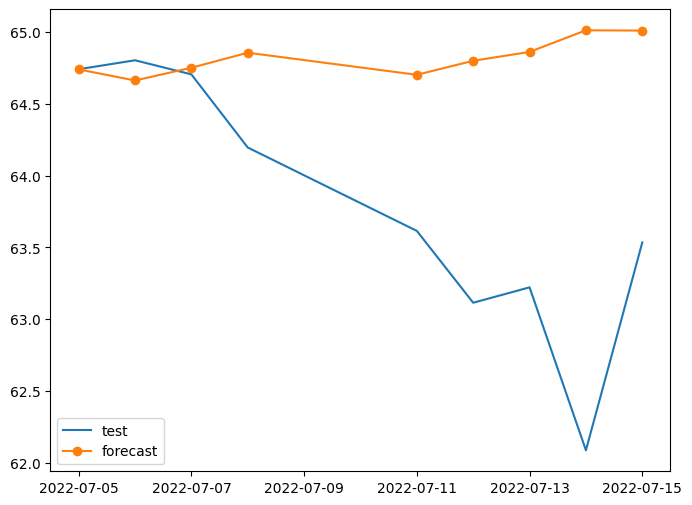

Average MAPE: 0.030505101141195635
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.028544537569352334


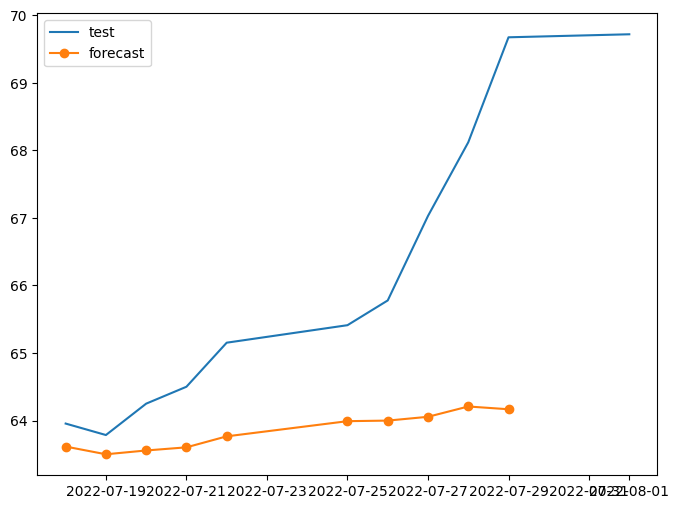

Average MAPE: 0.03032686808920988
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.02608030107244685


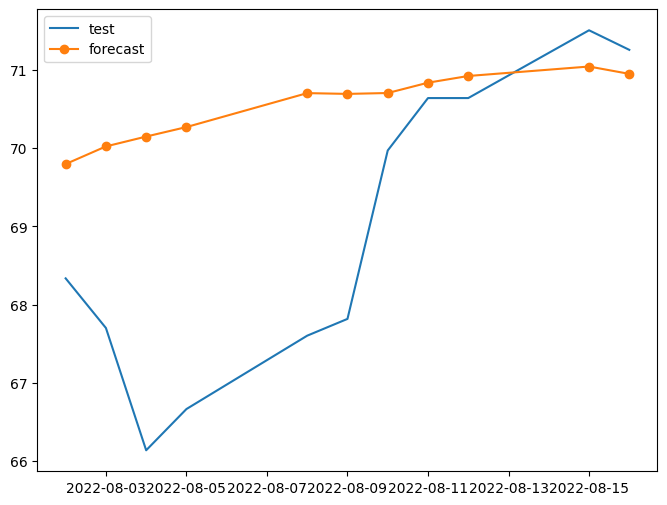

Average MAPE: 0.029972987504479628
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.041140273744843706


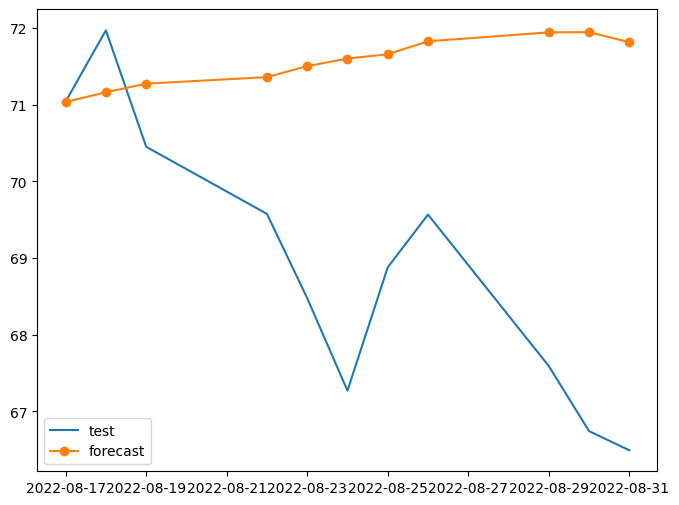

Average MAPE: 0.03083200952296917
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.01497675891666211


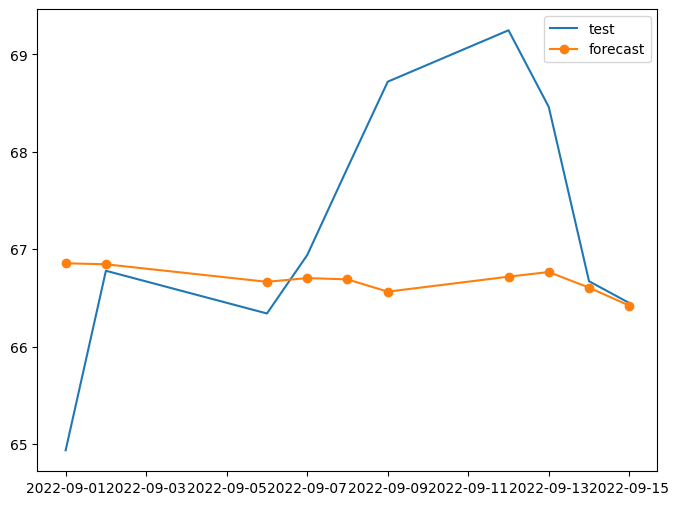

Average MAPE: 0.029699491622518667
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.07881271400461393


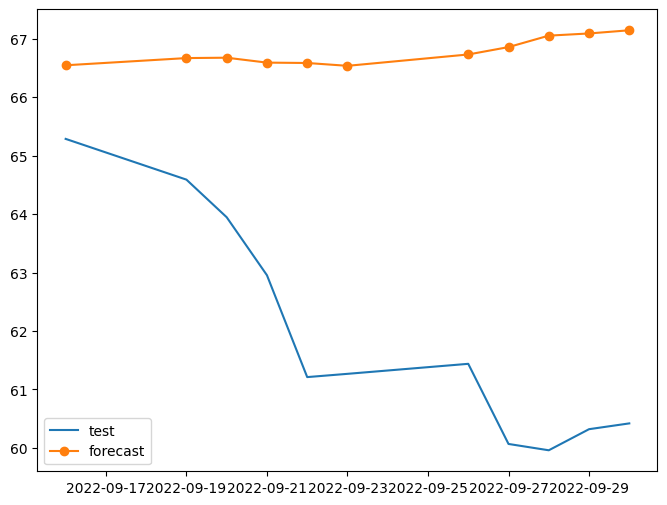

Average MAPE: 0.032973706447991684
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.05549208878115911


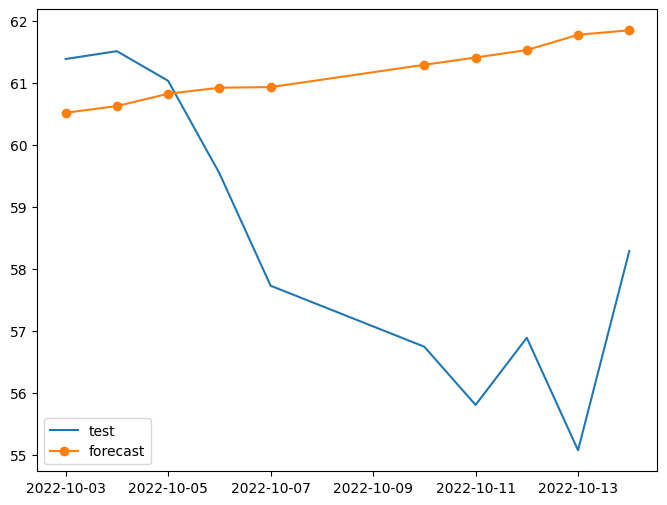

Average MAPE: 0.034381105343814646
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.013419003882798344


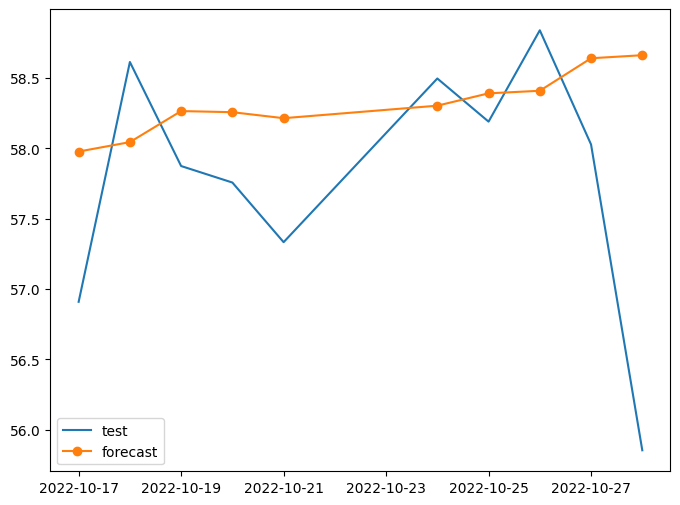

Average MAPE: 0.03314804055199016
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Uwaga: tylko 5 punktów do ewaluacji
MAPE:  0.011375238308889075


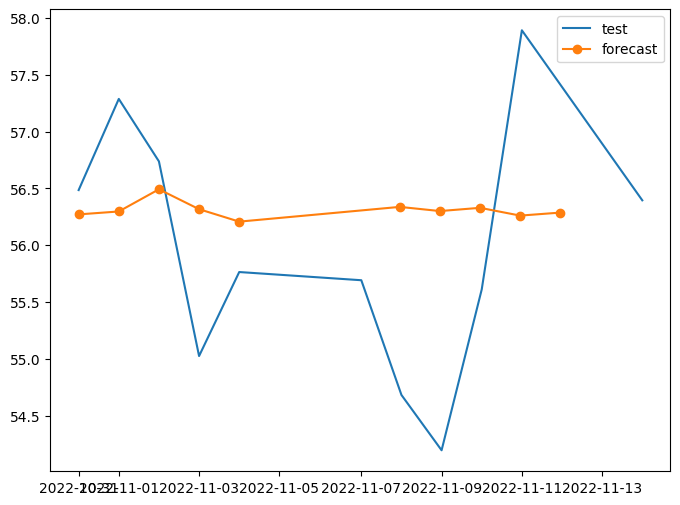

Average MAPE: 0.031938440427373434
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.007272998924257509


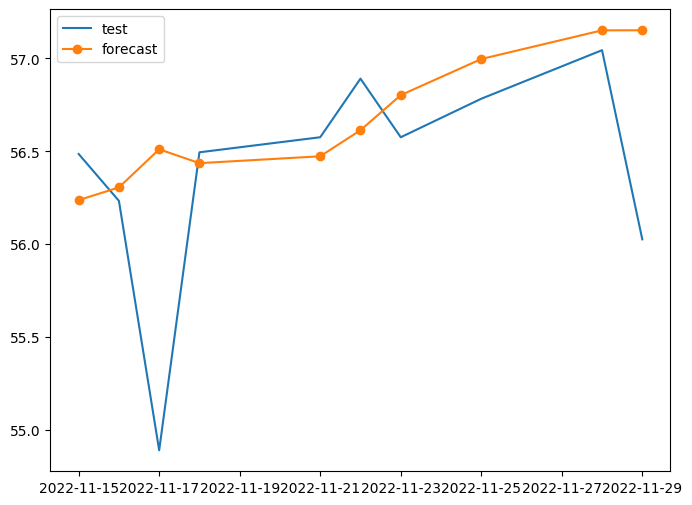

Average MAPE: 0.03064025929563049
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.01775105123784848


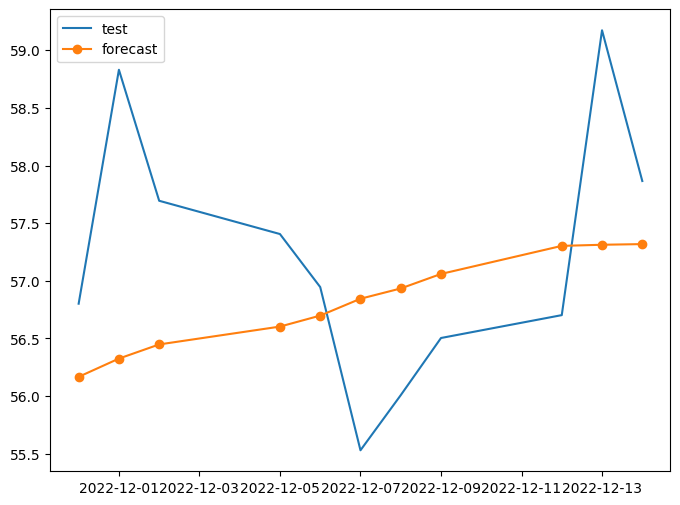

Average MAPE: 0.02999579889274139
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.08400260771533877


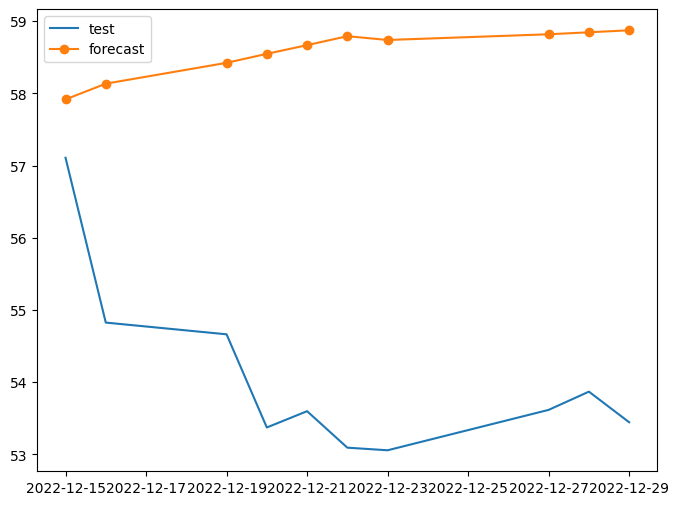

Average MAPE: 0.032567551693817455
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.013424832714963544


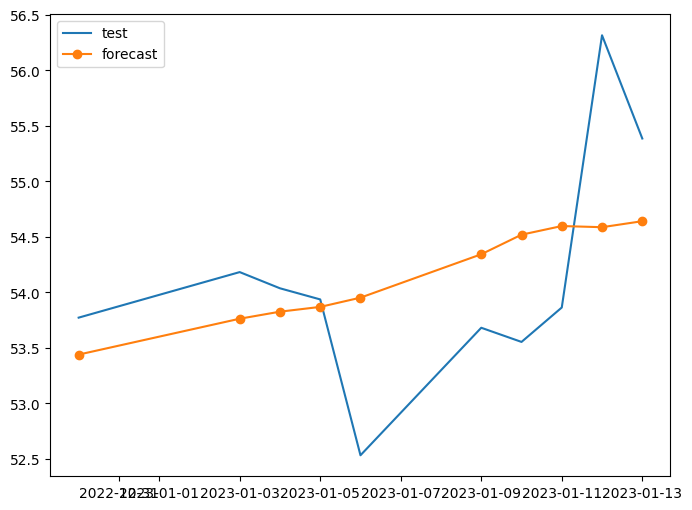

Average MAPE: 0.031697428103869545


In [ ]:
tfm_opt = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=16,
          horizon_len=16,
          num_layers=50,
          use_positional_embedding=False,
          context_len=1088,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

date_list = pd.date_range(start_date, periods=22, freq="15d").tolist()

df_opt_forecasts=[]
mapes_opt=[]

for d in date_list:
  train_df = df[df['ds'] < d].copy()
  subtest = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=15))]

  forecast_df = tfm_opt.forecast_on_df(
      inputs=train_df,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )

  df_opt_forecasts.append(forecast_df)
  forecast_subset = forecast_df[forecast_df['ds'].dt.date.isin(subtest['ds'].dt.date)]

  merged = pd.merge(
        subtest[['ds','Open']],
        forecast_df[['ds','timesfm']],
        on='ds',
        how='inner'
  )

  if len(merged) < 9:
    print(f"Uwaga: tylko {len(merged)} punktów do ewaluacji")

  mape=mean_absolute_percentage_error(merged['Open'], merged['timesfm'])
  print("MAPE: ", mape)
  mapes_opt.append(mape)

  plt.figure(figsize=(8,6))
  plt.plot(subtest['ds'], subtest['Open'], label="test")
  plt.plot(forecast_subset['ds'], forecast_subset['timesfm'], label="forecast", marker='o')
  plt.legend()
  plt.show()

  print("Average MAPE:", sum(mapes_opt)/len(mapes_opt))

Initial parameters - Average MAPE: 0.05261562111733305  
Optimized parameters - Average MAPE: 0.031697428103869545

Do testu:
Best params: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1632, 'horizon_len': 16, 'per_core_batch_size': 32}


In [23]:
import optuna
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import timesfm

# 1) Zdefiniuj mapę dostępnych checkpointów → konieczne architektury
checkpoint_options = {
    "google/timesfm-1.0-200m-pytorch": dict(
        num_layers=20,
        model_dims=1280,
        input_patch_len=32,
        output_patch_len=128,
    ),
    "google/timesfm-2.0-500m-pytorch": dict(
        num_layers=50,
        model_dims=1280,
        input_patch_len=32,
        output_patch_len=128,
    ),
    # ew. dopisać kolejne warianty
}

def objective(trial):
    # 2) wybierz checkpoint (wariant modelu)
    ckpt_id = trial.suggest_categorical("checkpoint", list(checkpoint_options.keys()))
    arch    = checkpoint_options[ckpt_id]

    # 3) stroimy tylko "shape-safe" parametry
    context_len         = trial.suggest_int("context_len", 256, 2048, step=32)
    horizon_len         = trial.suggest_int("horizon_len", 16, 128, step=16)
    per_core_batch_size = trial.suggest_categorical("per_core_batch_size", [16, 32, 64])

    # 4) budujemy TimesFmHparams z odpowiednią architekturą
    hparams = timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=per_core_batch_size,
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=arch["input_patch_len"],
        output_patch_len=arch["output_patch_len"],
        num_layers=arch["num_layers"],
        model_dims=arch["model_dims"],
        use_positional_embedding=False,
    )

    # 5) tworzysz checkpoint dopasowany do trialu
    checkpoint = timesfm.TimesFmCheckpoint(huggingface_repo_id=ckpt_id)

    # 6) inicjalizacja i szybka walidacja
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)
    mapes = []

    date_list = pd.date_range(
    start=start_date,
    periods=int(22 * 30 / horizon_len),
    freq=f"{horizon_len}D"       # <-- dodajemy "D" dla dni
    ).tolist()

    for d in date_list[:5]:
        train_df = df[df['ds'] < d]
        subtest  = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=horizon_len))]
        fc       = tfm.forecast_on_df(train_df, freq="1D", value_name="Open", num_jobs=-1)

        merged = pd.merge(
            subtest[['ds','Open']],
            fc[['ds','timesfm']],
            on='ds',
            how='inner'
        )
        if len(merged) < 2:
            return float('inf')
        mapes.append(mean_absolute_percentage_error(merged['Open'], merged['timesfm']))

    return sum(mapes) / len(mapes)

# 7) uruchom Optunę
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(objective, n_trials=20)

print("Best MAPE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-04-27 19:02:25,915] A new study created in memory with name: no-name-cb425fa1-02c3-4dcc-99b0-25f3a088f154


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:05:02,083] Trial 0 finished with value: 0.0528731857289423 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1632, 'horizon_len': 32, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:05:51,806] Trial 1 finished with value: 2.7073323231073516 and parameters: {'checkpoint': 'google/timesfm-1.0-200m-pytorch', 'context_len': 1216, 'horizon_len': 32, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:06:31,330] Trial 2 finished with value: 0.1044883860210581 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 416, 'horizon_len': 64, 'per_core_batch_size': 16}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:10:22,830] Trial 3 finished with value: 0.07961474937497143 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1248, 'horizon_len': 64, 'per_core_batch_size': 64}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:11:48,958] Trial 4 finished with value: 0.05750453994439231 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 800, 'horizon_len': 96, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:12:05,306] Trial 5 finished with value: 0.31989827447313746 and parameters: {'checkpoint': 'google/timesfm-1.0-200m-pytorch', 'context_len': 384, 'horizon_len': 112, 'per_core_batch_size': 16}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:14:25,259] Trial 6 finished with value: 0.5859396084467312 and parameters: {'checkpoint': 'google/timesfm-1.0-200m-pytorch', 'context_len': 2048, 'horizon_len': 32, 'per_core_batch_size': 64}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:14:57,070] Trial 7 finished with value: 37.2468676586476 and parameters: {'checkpoint': 'google/timesfm-1.0-200m-pytorch', 'context_len': 384, 'horizon_len': 32, 'per_core_batch_size': 64}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:15:36,657] Trial 8 finished with value: 0.3098560207237197 and parameters: {'checkpoint': 'google/timesfm-1.0-200m-pytorch', 'context_len': 2016, 'horizon_len': 80, 'per_core_batch_size': 16}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:17:07,815] Trial 9 finished with value: 0.09870020694720878 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 864, 'horizon_len': 64, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.0528731857289423.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:19:34,182] Trial 10 finished with value: 0.035760505205186525 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1536, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 10 with value: 0.035760505205186525.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:22:06,684] Trial 11 finished with value: 0.03507471702202797 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1632, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:24:36,344] Trial 12 finished with value: 0.03550732116269801 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1600, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:27:10,938] Trial 13 finished with value: 0.036412867231453344 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1664, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:29:28,244] Trial 14 finished with value: 0.0578532954661767 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1440, 'horizon_len': 48, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:32:30,559] Trial 15 finished with value: 0.040579556227938185 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1856, 'horizon_len': 128, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:35:13,559] Trial 16 finished with value: 0.0354338113482088 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1792, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:37:59,515] Trial 17 finished with value: 0.05913225846022794 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1824, 'horizon_len': 48, 'per_core_batch_size': 32}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:41:59,072] Trial 18 finished with value: 0.05924183994790568 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1376, 'horizon_len': 48, 'per_core_batch_size': 64}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-04-27 19:42:59,072] Trial 19 finished with value: 0.035614863615430925 and parameters: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 960, 'horizon_len': 16, 'per_core_batch_size': 16}. Best is trial 11 with value: 0.03507471702202797.


Finished forecasting.
Best MAPE: 0.03507471702202797
Best params: {'checkpoint': 'google/timesfm-2.0-500m-pytorch', 'context_len': 1632, 'horizon_len': 16, 'per_core_batch_size': 32}
